Importer les données de Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "/content/gdrive/My Drive/Gym_trainer/openpose/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Importer les différents modules python

In [2]:
import numpy as np

from itertools import product
from keras.layers import  BatchNormalization, Convolution1D, Dense, Dropout, Flatten, MaxPooling1D, SpatialDropout1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from pickle import load

Using TensorFlow backend.


Afficher l'historique du modèle

In [0]:
def print_history(history):
  """Summarize history by printing the loss of the model."""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Remplir les matrices avec des 0 pour qu'elles aient toutes la même taille

In [0]:
def pad_matrices(matrix_list):
  """Pad matrices with 0."""
  max_length = 0
  new_matrix_list = []
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape[1]
    if shape > max_length:
      max_length = shape
  for i in range(len(matrix_list)):
    shape = matrix_list[i].shape
    if shape[0] < max_length: # matrix_list[1].shape[0]
      pad_length = max_length - shape[1]
      pad = np.zeros((2, pad_length, shape[2]))
      new_matrix = np.append(matrix_list[i], pad, axis=1)
    else:
      new_matrix = matrix_list[i]
    new_matrix_list.append(new_matrix)
  new_matrix_list = np.array(new_matrix_list)
  return new_matrix_list

Découper les données entre ensemble de test et ensemble d'apprentissage

In [0]:
def split_data(X, y, indice):
  """Split data betwenn train set and test set."""
  X_test = []
  y_test = []
  X_train = []
  y_train = []
  for i in range(len(y)):
    if i < indice:
      X_test.append(X[i])
      y_test.append(y[i])
    else:
      X_train.append(X[i])
      y_train.append(y[i])
  X_test = np.array(X_test)
  y_test = np.array(y_test)
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  return (X_test , y_test, X_train, y_train)

Transformer les données

In [0]:
def transform_matrices(X):
  """Transform data."""
  shape = X.shape
  new_X = np.zeros((shape[0], shape[2], shape[1] * shape[3]))
  for i in range(shape[0]):
    for j in range(shape[2]):
      new_X[i, j ,:] = np.reshape(X[i, :, j, :], (1, shape[1] * shape[3]))
  return new_X

Supprimer les zéros lorsqu'une articulation n'est pas détectée

In [0]:
def delete_zeros(X):
  """Delete zeros in matrices and replace them with the previous value."""
  for i in range(len(X)):
    matrix = X[i]
    shape = matrix.shape
    for (j,k) in product(range(shape[1]), range(shape[2])):
      if matrix[0, j, k] == 0:
        matrix[:, j, k] = matrix[:, j - 1, k]
  X[i] = matrix
  return X

Normaliser les données

In [0]:
def standardize(X):
  """Standardize data according to a normal distribution."""
  for i in range(X.shape[2]):
    mu = np.mean(X[:, :, i])
    sigma = np.std(X[:, :, i])
    if sigma != 0:
      X[:, :, i] = (X[:, :, i] - mu) / sigma
  return X

Définir le modèle du CNN

In [0]:
def define_model(dim1, dim2):
  """Define the model of the CNN with (dim1, dim2) as input shape."""
  shape = (dim1, dim2)
  model = Sequential()
  model.add(Convolution1D(16, 5, activation='relu', kernel_regularizer=l2(0.01),
                          activity_regularizer=l1(0.01), input_shape=shape))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(32, 5, activation='relu', kernel_regularizer=l2(0.01),
                          activity_regularizer=l1(0.01)))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Convolution1D(64, 5, activation='relu', kernel_regularizer=l2(0.01),
                          activity_regularizer=l1(0.01)))
  model.add(MaxPooling1D(3))
  model.add(SpatialDropout1D(0.2))
  model.add(Flatten())
  model.add(Dense(100,  activation='relu',kernel_regularizer=l2(0.01),
                  activity_regularizer=l1(0.01)))
  model.add(Dropout(0.5))
  model.add(Dense(1,  activation='linear' ,kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01)))
  model.summary()
  return model

Afficher les résultats du modèle



In [0]:
def print_results(model, X_test, y_test, X_train, y_train):
  """Print the results of the model."""
  predict_test = model.predict(X_test)
  RMSE_test = np.linalg.norm(predict_test - y_test) / len(y_test)
  print("RMSE test", RMSE_test)
  predict_test = predict_test.flatten()
  corr = np.corrcoef(y_test, predict_test)
  print("corr test", corr[0,1])
  plt.plot(y_test, np.array(predict_test), '.r')
  plt.title('Predicted/real values on test set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()
  predict_train = model.predict(X_train)
  RMSE_train = np.linalg.norm(predict_train - y_train) / len(y_train)
  print("RMSE train", RMSE_train)
  predict_train = predict_train.flatten()
  corr = np.corrcoef(y_train, predict_train)
  print("corr test", corr[0,1])
  plt.plot(y_train, np.array(predict_train), '.r')
  plt.title('Predicted/real values on train set')
  plt.xlabel('real values')
  plt.ylabel('predicted values')
  plt.show()

Charger les données

In [0]:
X = load(open(PATH + "Matrices.p", "rb"))
Personnes = np.load(PATH + 'Personnes.npy')
y = np.load(PATH + 'Notes.npy')

Réduire le nombre d'articulations

In [0]:
for i in range(len(X)):
	X[i] = X[i][:,:,0:9] #8

Traiter les données

In [0]:
X = delete_zeros(X)
X = pad_matrices(X)
X = transform_matrices(X)
X = standardize(X)

Séparer les données

In [0]:
indice = 35
X_test , y_test, X_train, y_train = split_data(X,y, indice)

Créer le modèle

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 318, 16)           1456      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 106, 16)           0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 106, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 102, 32)           2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 32)            0         
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 34, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 64)           

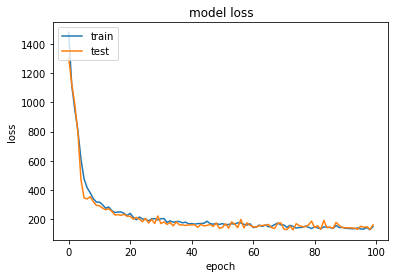

In [15]:
optimizer = Adam(lr=.001)
nb_epochs = 100
model = define_model(X.shape[1], X.shape[2])
model.compile(loss='MSE', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=nb_epochs, verbose=0,
                   validation_data=(X_test, y_test), shuffle=True)
print_history(history)

Récupérer les résultats du modèle

RMSE test 9.8213515049353
corr test -0.004219642109514495


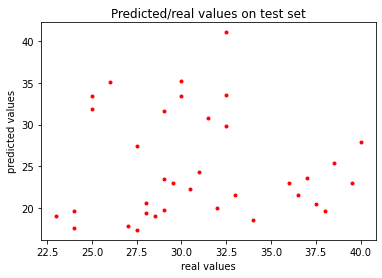

RMSE train 11.530515136221753
corr test 0.6780252124758241


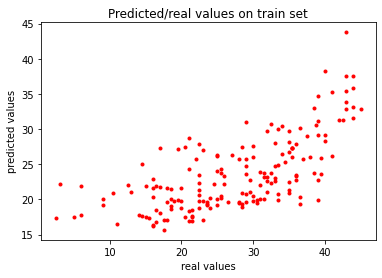

In [16]:
print_results(model, X_test, y_test, X_train, y_train)

Sauvegarder le modèle

In [0]:
model.save(PATH+"cnn_test3_3.h5")